In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

# plt.rc("font", family="serif",) #serif="Times"
# plt.rc("font", family= "Times New Roman")
plt.rc("font", family="serif", serif="Computer Modern")
plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=true)

In [3]:
function hist_2d(smpls, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

function hist_1d(smpls, dim_1; nbins=40)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    hist_tmp = fit(Histogram, smpl_tmp[dim_1,:], FrequencyWeights(smpl_w), nbins=nbins)
    hist_tmp = normalize(hist_tmp, mode=:pdf)
    return hist_tmp
end

hist_1d (generic function with 1 method)

In [4]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058

prior_41 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.35 .. 1.0, 
        waist = [truncated(Normal(2.774, 0.03), 2.5, 3.6)],
        waist_2 = [truncated(Normal(2.774, 0.03), 2.5, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.47799, 15.025999, 23.1644],
);

prior_35 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)], #core
        tr_size_2 = [0.1, 0.1],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [2.0, 2.0],
        mixt_pow =  1.0 , 
        waist = [truncated(Normal(2.774, 0.03), 2.5, 3.6)],
        waist_2 = [2.774], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    ); 

In [5]:
smpl_35 = bat_read("../../data/sampling_results/Benchmark-8/samples-35.hdf5").result
smpl_35 = varshape(prior_35).(smpl_35);

In [6]:
smpl_41 = bat_read("../../data/sampling_results/Benchmark-8/samples-41.hdf5").result
smpl_41 = varshape(prior_41).(smpl_41);

In [7]:
mode_35 = mode(smpl_35)
mode_41 = mode(smpl_41);

In [8]:
hist_35_12 = hist_2d(smpl_35, 1,2);
hist_35_34 = hist_2d(smpl_35, 3,4);
hist_35_11 = hist_1d(smpl_35, 5);

In [9]:
hist_41_12 = hist_2d(smpl_41, 1,2);
hist_41_34 = hist_2d(smpl_41, 3,4);
hist_41_56 = hist_2d(smpl_41, 5,6);
hist_41_78 = hist_2d(smpl_41, 7,8);
hist_41_10 = hist_1d(smpl_41, 10);
hist_41_11 = hist_1d(smpl_41, 11);

In [10]:
fig, ax = plt.subplots(1,3, figsize=(12,5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1].contour(midpoints(hist_35_11.edges[1]), midpoints(hist_35_11.edges[2]), hist_35_11.weights', 
    levels=range(minimum(hist_35_11.weights'), maximum(hist_35_11.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[2].contour(midpoints(hist_35_34.edges[1]), midpoints(hist_35_34.edges[2]), hist_35_34.weights', 
    levels=range(minimum(hist_35_34.weights'), maximum(hist_35_34.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[3].step(midpoints(hist_35_1.edges[1]), hist_35_1.weights, color="C0")

ax[1].contour(midpoints(hist_41_12.edges[1]), midpoints(hist_41_12.edges[2]), hist_41_12.weights', 
    levels=range(minimum(hist_41_12.weights'), maximum(hist_41_12.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[1].contour(midpoints(hist_41_34.edges[1]), midpoints(hist_41_34.edges[2]), hist_41_34.weights', 
    levels=range(minimum(hist_41_34.weights'), maximum(hist_41_34.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[2].contour(midpoints(hist_41_56.edges[1]), midpoints(hist_41_56.edges[2]), hist_41_56.weights', 
    levels=range(minimum(hist_41_56.weights'), maximum(hist_41_56.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[2].contour(midpoints(hist_41_78.edges[1]), midpoints(hist_41_78.edges[2]), hist_41_78.weights', 
    levels=range(minimum(hist_41_78.weights'), maximum(hist_41_78.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[3].step(midpoints(hist_41_10.edges[1]), hist_41_10.weights, color="C1")

ax[3].step(midpoints(hist_41_11.edges[1]), hist_41_11.weights, color="C1")

LoadError: BoundsError: attempt to access Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}} at index [2]

In [11]:
hist_35_1 = hist_2d(smpl_35, 17,20)
hist_35_2 = hist_2d(smpl_35, 18,21)
hist_35_3 = hist_2d(smpl_35, 18,22)
hist_35_4 = hist_2d(smpl_35, 23,24);

LoadError: BoundsError: attempt to access 21×566713 Matrix{Float64} at index [22, 1:566713]

In [12]:
hist_41_1 = hist_2d(smpl_41, 23,26)
hist_41_2 = hist_2d(smpl_41, 24,27)
hist_41_3 = hist_2d(smpl_41, 25,28)
hist_41_4 = hist_2d(smpl_41, 29,30);

LoadError: BoundsError: attempt to access 27×558790 Matrix{Float64} at index [28, 1:558790]

In [13]:
fig, ax = plt.subplots(1,4, figsize=(15,5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1].contour(midpoints(hist_35_1.edges[1]), midpoints(hist_35_1.edges[2]), hist_35_1.weights', 
    levels=range(minimum(hist_35_1.weights'), maximum(hist_35_1.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[1].contour(midpoints(hist_41_1.edges[1]), midpoints(hist_41_1.edges[2]), hist_41_1.weights', 
    levels=range(minimum(hist_41_1.weights'), maximum(hist_41_1.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[2].contour(midpoints(hist_35_2.edges[1]), midpoints(hist_35_2.edges[2]), hist_35_2.weights', 
    levels=range(minimum(hist_35_2.weights'), maximum(hist_35_2.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[2].contour(midpoints(hist_41_2.edges[1]), midpoints(hist_41_2.edges[2]), hist_41_2.weights', 
    levels=range(minimum(hist_41_2.weights'), maximum(hist_41_2.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 


ax[3].contour(midpoints(hist_35_3.edges[1]), midpoints(hist_35_3.edges[2]), hist_35_3.weights', 
    levels=range(minimum(hist_35_3.weights'), maximum(hist_35_3.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[3].contour(midpoints(hist_41_3.edges[1]), midpoints(hist_41_3.edges[2]), hist_41_3.weights', 
    levels=range(minimum(hist_41_3.weights'), maximum(hist_41_3.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 

ax[4].contour(midpoints(hist_35_4.edges[1]), midpoints(hist_35_4.edges[2]), hist_35_4.weights', 
    levels=range(minimum(hist_35_4.weights'), maximum(hist_35_4.weights'), length=11)[2:end], #corner_mask= true,
    colors="C0", alpha=0.8, antialiased=true) 

ax[4].contour(midpoints(hist_41_4.edges[1]), midpoints(hist_41_4.edges[2]), hist_41_4.weights', 
    levels=range(minimum(hist_41_4.weights'), maximum(hist_41_4.weights'), length=11)[2:end], #corner_mask= true,
    colors="C1", alpha=0.8, antialiased=true) 


LoadError: UndefVarError: hist_35_3 not defined

In [14]:
function rad(sgm, sigmap, waist)
    return f(x) = sqrt.(sgm^2 + 10^-4*sigmap^2*(waist - x)^2)
end

rad (generic function with 1 method)

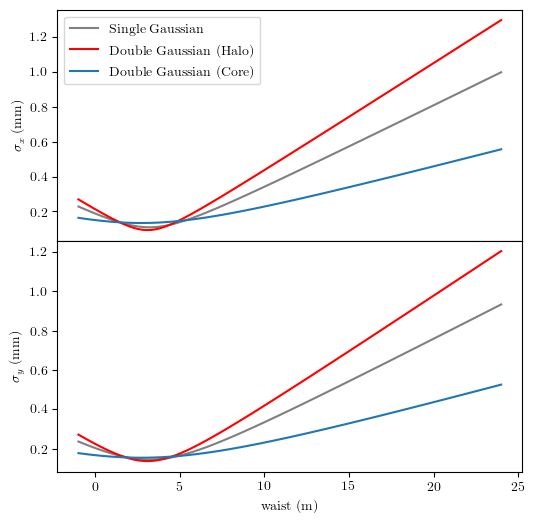

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


PyObject Text(24.336632052546015, 0.5, '$\\sigma_x \\; (\\mathrm{mm})$')

In [15]:
x_range = range(-1, stop = 24, length=100)

fig, (ax, ax2)= plt.subplots(2,1, figsize=(6,6), sharex=true)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

ax.plot(x_range, rad(mode_35.tr_size[1], mode_35.ang_spr[1], mode_35.waist[1]).(x_range), color="gray", label="Single Gaussian")
ax.plot(x_range, rad(mode_41.tr_size[1], mode_41.ang_spr[1], mode_41.waist[1]).(x_range), color="red", label="Double Gaussian (Halo)")
ax.plot(x_range, rad(mode_41.tr_size_2[1], mode_41.ang_spr_2[1], mode_41.waist_2[1]).(x_range), color="C0", label="Double Gaussian (Core)")


ax2.plot(x_range, rad(mode_35.tr_size[2], mode_35.ang_spr[2], mode_35.waist[1]).(x_range), color="gray")
ax2.plot(x_range, rad(mode_41.tr_size[2], mode_41.ang_spr[2], mode_41.waist[1]).(x_range), color="red")
ax2.plot(x_range, rad(mode_41.tr_size_2[2], mode_41.ang_spr_2[2], mode_41.waist_2[1]).(x_range), color="C0")

ax.legend()
ax2.set_xlabel(L"\mathrm{waist \; (m)}")
ax2.set_ylabel(L"\sigma_y \; (\mathrm{mm})")
ax.set_ylabel(L"\sigma_x \; (\mathrm{mm})")


In [16]:
s1 = rad(mode_35.tr_size[1], mode_35.ang_spr[1], mode_35.waist[1]).(x_range);

In [17]:
xmin, xmax = -1.5, 24.4
x_axis = range(xmin, stop=xmax, length=50)

params = (σ=0.2, σp = 4.0, s=2.775)
cam_pos = [0.0, 1.478, 15.026, 23.164]
σ_x(x) = sqrt.(params.σ^2 + 10^-4*params.σp^2*(params.s - x)^2) 

y_vals = σ_x.(x_axis);

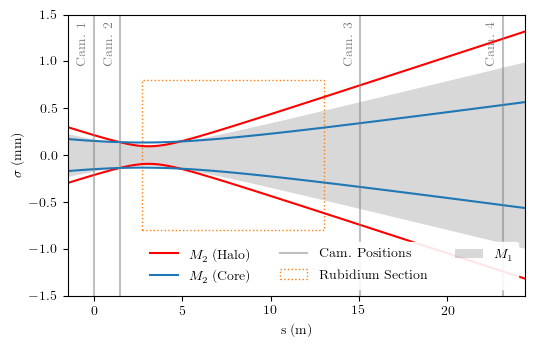

In [22]:
x_range = range(xmin, stop = xmax, length=100)

fig, ax= plt.subplots(1,1, figsize=(5.905631659056317, 3.649881090334235), sharex=true)
fig.subplots_adjust(hspace=0.0, wspace=0.0)
ax.fill_between(x_range, s1, -s1, color="gray", label=L"M_1", alpha=0.3,  lw=0.0, )

ax.plot(x_range, rad(mode_41.tr_size[1], mode_41.ang_spr[1], mode_41.waist[1]).(x_range), color="red", label=L"M_2\;\textup{(Halo)}")
ax.plot(x_range, rad(mode_41.tr_size_2[1], mode_41.ang_spr_2[1], mode_41.waist_2[1]).(x_range), color="C0", label=L"M_2\;\textup{(Core)}")
ax.plot(x_range, -rad(mode_41.tr_size[1], mode_41.ang_spr[1], mode_41.waist[1]).(x_range), color="red",)
ax.plot(x_range, -rad(mode_41.tr_size_2[1], mode_41.ang_spr_2[1], mode_41.waist_2[1]).(x_range), color="C0", )

ax.set_xlabel(L"\mathrm{s \; (m)}")
ax.set_ylabel(L"\sigma \; (\mathrm{mm})")


proxy = plt.Rectangle((807.3505-804.625, -0.8), 817.6505 - 807.3505, 1.6, fc = "None", ec=:C1, ls=:dotted, label="Rubidium Section")
ax.add_patch(proxy)


[ax.axvline(i, linestyle="-", color="gray", alpha=0.5) for i in cam_pos]
ax.axvline(-10, linestyle="-", color="gray", alpha=0.5, label="Cam. Positions")
# ax.axhline(0, linestyle="-", color="black", alpha=0.5) 


ax.text(cam_pos[1]-1,0.97, "Cam. 1", color="gray", rotation="vertical")
ax.text(cam_pos[2]-1,0.97, "Cam. 2", color="gray", rotation="vertical")
ax.text(cam_pos[3]-1,0.97, "Cam. 3", color="gray", rotation="vertical")
ax.text(cam_pos[4]-1,0.97, "Cam. 4", color="gray", rotation="vertical")

ax.legend(loc="lower right", ncol=3, framealpha=0.9, edgecolor=:white)

ax.set_xlim(xmin, xmax)
ax.set_ylim(-1.5, 1.5)

fig.savefig("../../plots/m1-m2-comp.pdf", bbox_inches = "tight")